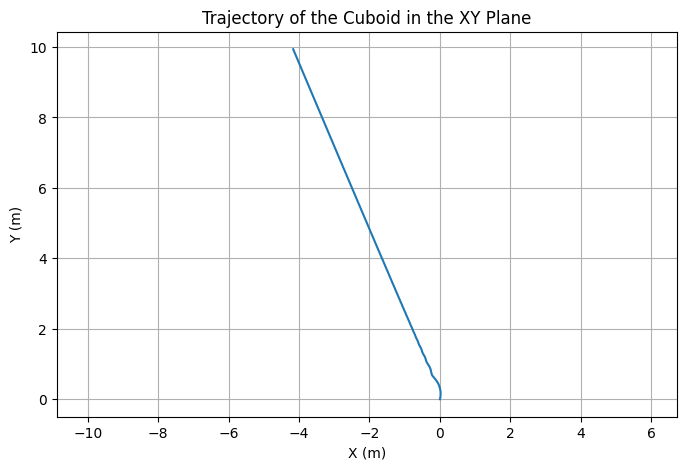

In [7]:
# Perpendicular Cuboid in Prescribed Flow Field
# Author: DIEP Thanh Phuong
# Description: Quaternion-based rigid body simulation of a cuboid in a flow field

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ------------------------------
# Helper Functions
# ------------------------------

def quaternion_multiply(q, r):
    """Quaternion multiplication: q ⊗ r"""
    w0, x0, y0, z0 = q
    w1, x1, y1, z1 = r
    return np.array([
        w0*w1 - x0*x1 - y0*y1 - z0*z1,
        w0*x1 + x0*w1 + y0*z1 - z0*y1,
        w0*y1 - x0*z1 + y0*w1 + z0*x1,
        w0*z1 + x0*y1 - y0*x1 + z0*w1
    ])

def quaternion_conjugate(q):
    """Quaternion conjugate"""
    return np.array([q[0], -q[1], -q[2], -q[3]])

def rotate_vector_by_quaternion(v, q):
    """Rotate vector v by quaternion q"""
    v_quat = np.concatenate(([0.0], v))
    return quaternion_multiply(quaternion_multiply(q, v_quat), quaternion_conjugate(q))[1:]

# ------------------------------
# System Parameters
# ------------------------------

m = 0.05       # mass (kg)
a, b, c = 1.0, 0.5, 0.3  # cuboid dimensions (m)

I_x = (1/12) * m * (b**2 + c**2)
I_y = (1/12) * m * (a**2 + c**2)
I_z = (1/12) * m * (a**2 + b**2)
I = np.diag([I_x, I_y, I_z])

# ------------------------------
# Aerodynamic Force Model (Placeholder)
# ------------------------------

def aerodynamic_force_body(t, state):
    """Compute aerodynamic force in the body frame"""
    # Placeholder: Constant drag force in body x-direction
    return np.array([0.05, 0.2, 0.0])  # [Cx, Cy, Cz]

def aerodynamic_moment_body(t, state):
    """Compute aerodynamic torque in the body frame"""
    return np.array([0.01, 0.0, 0.1])  # Constant torque around z

# ------------------------------
# ODE System
# ------------------------------

def dynamics(t, y):
    # State vector: [R, V, q, ω]
    R = y[0:3]     # Position (inertial)
    V = y[3:6]     # Velocity (inertial)
    q = y[6:10]    # Orientation (quaternion)
    omega = y[10:13]  # Angular velocity (body)

    # Normalize quaternion
    q = q / np.linalg.norm(q)

    # Forces
    F_body = aerodynamic_force_body(t, y)
    F_inertial = rotate_vector_by_quaternion(F_body, q)
    a = F_inertial / m

    # Moments
    M_body = aerodynamic_moment_body(t, y)
    omega_cross_Iomega = np.cross(omega, I @ omega)
    domega_dt = np.linalg.inv(I) @ (M_body - omega_cross_Iomega)

    # Quaternion kinematics
    omega_quat = np.array([0.0, *omega])
    dq_dt = 0.5 * quaternion_multiply(q, omega_quat)

    # Output derivative of the state
    return np.concatenate([
        V,        # dR/dt = V
        a,        # dV/dt = F/m
        dq_dt,    # dq/dt = 1/2 * q ⊗ ω
        domega_dt # dω/dt
    ])

# ------------------------------
# Initial Conditions
# ------------------------------

R0 = np.array([0.0, 0.0, 0.0])         # initial position
V0 = np.array([0.0, 0.0, 0.0])         # initial velocity
q0 = np.array([1.0, 0.0, 0.0, 0.0])    # initial orientation (identity quaternion)
omega0 = np.array([0.0, 0.0, 0.0])     # initial angular velocity

y0 = np.concatenate([R0, V0, q0, omega0])

# ------------------------------
# Integrate System
# ------------------------------

t_span = (0, 10)
t_eval = np.linspace(*t_span, 1000)

sol = solve_ivp(dynamics, t_span, y0, t_eval=t_eval, rtol=1e-8, atol=1e-10)

# ------------------------------
# Plot Position Trajectory
# ------------------------------

fig = plt.figure(figsize=(8, 5))
plt.plot(sol.y[0], sol.y[1])
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Trajectory of the Cuboid in the XY Plane')
plt.grid()
plt.axis('equal')
plt.show()
